In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
def simulate_heston_paths(
    n_paths=20000,
    T=1.0,
    N=252,
    S0=100.0,
    v0=0.04,
    r=0.01,
    kappa=2.0,
    theta=0.04,
    eta=0.5,
    rho=-0.7,
    seed=None,
):

    rng = np.random.default_rng(seed)
    dt = T / N
    S_paths = np.zeros((n_paths, N + 1), dtype=float)
    X_paths = np.zeros((n_paths, N + 1), dtype=float)
    v_paths = np.zeros((n_paths, N + 1), dtype=float)

    S_paths[:, 0] = S0
    X_paths[:, 0] = np.log(S0)
    v_paths[:, 0] = v0

    for n in range(N):
        v_curr = np.maximum(v_paths[:, n], 1e-8)
        X_curr = X_paths[:, n]

        z1 = rng.normal(0.0, 1.0, size=n_paths)
        z2 = rng.normal(0.0, 1.0, size=n_paths)
        dB1 = math.sqrt(dt) * z1
        dB2 = math.sqrt(dt) * z2

        dW1 = dB1
        dW2 = rho * dB1 + math.sqrt(1.0 - rho**2) * dB2

        dX = (r - 0.5 * v_curr) * dt + np.sqrt(v_curr) * dW1
        dv = kappa * (theta - v_curr) * dt + eta * np.sqrt(v_curr) * dW2

        X_next = X_curr + dX
        v_next = np.maximum(v_curr + dv, 1e-8)

        X_paths[:, n+1] = X_next
        v_paths[:, n+1] = v_next
        S_paths[:, n+1] = np.exp(X_next)

    return S_paths


def bs_call_price(S, K, r, sigma, T):
    if sigma <= 0 or T <= 0:
        return max(S - K * math.exp(-r * T), 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    from math import erf

    def norm_cdf(x):
        return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))

    return S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)


def implied_vol_bisection(price, S, K, r, T,
                          low=1e-4, high=3.0, tol=1e-6, max_iter=100):
    intrinsic = max(S - K * math.exp(-r*T), 0.0)
    if price <= intrinsic + 1e-6:
        return 0.0
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        c = bs_call_price(S, K, r, mid, T)
        if abs(c - price) < tol:
            return mid
        if c > price:
            high = mid
        else:
            low = mid
    return mid


def mc_call_prices_from_paths(S_paths, T_list, K_list, r, T_total):

    n_paths, N_plus = S_paths.shape
    N = N_plus - 1
    dt = T_total / N
    prices = {}
    for T in T_list:
        idx = min(int(round(T / dt)), N)
        S_T = S_paths[:, idx]
        for K in K_list:
            payoff = np.maximum(S_T - K, 0.0)
            price = math.exp(-r * T) * payoff.mean()
            prices[(T, K)] = price
    return prices


def compute_iv_surface(S_paths, S0, T_list, K_list, r, T_total):

    prices = mc_call_prices_from_paths(S_paths, T_list, K_list, r, T_total)
    H, W = len(T_list), len(K_list)
    iv = np.zeros((H, W), dtype=float)
    for i, T in enumerate(T_list):
        for j, K in enumerate(K_list):
            c = prices[(T, K)]
            iv[i, j] = implied_vol_bisection(c, S0, K, r, T)
    return iv



def smooth_surfaces_with_quadratic_smile(
    total_var: np.ndarray,
    maturities: np.ndarray,
    K_list: np.ndarray,
    S0: float,
    min_iv: float = 0.05,
    max_iv: float = 1.0,
    invalid_iv_thresh: float = 1e-3,
) -> np.ndarray:
    N, H, W = total_var.shape
    T_arr = np.asarray(maturities, dtype=float)
    K_arr = np.asarray(K_list, dtype=float)
    M_arr = K_arr / float(S0)
    x_all = np.log(M_arr)  # log‑moneyness

    w_smooth = np.zeros_like(total_var, dtype=float)

    for n in range(N):
        for ti in range(H):
            T_val = float(T_arr[ti])
            w_row = total_var[n, ti, :]

            w_clipped = np.clip(w_row, 0.0, None)
            if T_val <= 0:
                w_smooth[n, ti, :] = w_clipped
                continue

            sigma_row = np.sqrt(w_clipped / T_val)  # IV row
            mask_valid = sigma_row > invalid_iv_thresh
            if mask_valid.sum() < 4:
                w_smooth[n, ti, :] = w_clipped
                continue

            x_valid = x_all[mask_valid]
            y_valid = sigma_row[mask_valid]

            coeffs = np.polyfit(x_valid, y_valid, deg=2)
            sigma_fit = np.polyval(coeffs, x_all)

            sigma_fit = np.clip(sigma_fit, min_iv, max_iv)
            w_smooth[n, ti, :] = (sigma_fit ** 2) * T_val

    return w_smooth


class IVSurfaceDatasetCond(Dataset):
    def __init__(self, n_samples=200, S0=100.0, r=0.01,
                 T_list=None, K_list=None,
                 T_total=1.0, n_paths_mc=2000, seed=0):

        if T_list is None:
            T_list = [0.25, 0.5, 1.0]
        if K_list is None:
            K_list = np.linspace(70, 130, 13)

        self.T_list = np.array(T_list, dtype=float)
        self.K_list = np.array(K_list, dtype=float)
        self.S0 = float(S0)

        rng = np.random.default_rng(seed)
        surfaces = []
        params = []

        base_kappa = 2.0
        base_theta = 0.04
        base_eta   = 0.5
        base_rho   = -0.7
        base_v0    = 0.04

        print("Generating conditional IV surface dataset...")
        for i in range(n_samples):
            kappa = base_kappa * (0.8 + 0.4 * rng.random())
            theta = base_theta * (0.7 + 0.6 * rng.random())
            eta   = base_eta   * (0.7 + 0.6 * rng.random())
            rho   = base_rho + 0.1 * rng.normal()
            rho   = float(np.clip(rho, -0.95, -0.05))
            v0    = base_v0 * (0.7 + 0.6 * rng.random())

            params.append([kappa, theta, eta, rho, v0])

            S_paths = simulate_heston_paths(
                n_paths=n_paths_mc, T=T_total, N=252,
                S0=S0, v0=v0, r=r,
                kappa=kappa, theta=theta, eta=eta, rho=rho,
                seed=rng.integers(0, 10_000_000)
            )
            iv = compute_iv_surface(S_paths, S0, self.T_list, self.K_list, r, T_total)
            surfaces.append(iv)

            if (i+1) % 20 == 0:
                print(f"  generated {i+1}/{n_samples} surfaces")

        surfaces = np.array(surfaces, dtype=np.float32)  # (N,H,W)
        params   = np.array(params,   dtype=np.float32)  # (N,5)

        self.params_raw = torch.from_numpy(params)   # (N,5)

        # total variance + smoothing
        tau = self.T_list.reshape(1, len(self.T_list), 1)
        total_var = (surfaces ** 2) * tau  # (N,H,W)

        total_var = smooth_surfaces_with_quadratic_smile(
            total_var,
            maturities=self.T_list,
            K_list=self.K_list,
            S0=S0,
            min_iv=0.05,
            max_iv=1.0,
            invalid_iv_thresh=1e-3,
        )

        self.mean = float(total_var.mean())
        self.std  = float(total_var.std() + 1e-8)
        total_var_norm = (total_var - self.mean) / self.std
        self.data = torch.from_numpy(total_var_norm.astype(np.float32)).unsqueeze(1)

        self.param_mean = self.params_raw.mean(dim=0, keepdim=True)      # (1,5)
        self.param_std  = self.params_raw.std(dim=0, keepdim=True) + 1e-8
        self.params = (self.params_raw - self.param_mean) / self.param_std  # (N,5)

        print("Conditional dataset shapes:")
        print("  surfaces:", self.data.shape, "  params:", self.params.shape)
        print("  tv normalized mean/std:",
              self.data.mean().item(), self.data.std().item())

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.params[idx]


class DiffusionConfig:
    def __init__(self, timesteps=200, beta_start=1e-4, beta_end=0.02):
        self.T = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        self.betas = betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)


def extract(a, t, x_shape):
    out = a[t]  # (B,)
    return out.view(-1, *([1] * (len(x_shape) - 1)))



def sinusoidal_embedding(timesteps, dim):
    device_ = timesteps.device
    half_dim = dim // 2
    freqs = torch.exp(
        -math.log(10000.0)
        * torch.arange(0, half_dim, device=device_).float()
        / half_dim
    )
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb


class TimeEmbedding(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, out_dim)
        self.act = nn.SiLU()
        self.linear2 = nn.Linear(out_dim, out_dim)

    def forward(self, t):
        emb = sinusoidal_embedding(t, self.linear1.in_features)
        emb = self.linear1(emb)
        emb = self.act(emb)
        emb = self.linear2(emb)
        return emb


class ParamEmbedding(nn.Module):
    def __init__(self, in_dim=5, hidden_dim=32, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.SiLU(),
        )

    def forward(self, z):
        return self.net(z)


class ResBlockCond(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act   = nn.SiLU()

        self.film = nn.Linear(cond_dim, 2 * out_ch)

        self.shortcut = (
            nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        )

    def forward(self, x, cond_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        gamma_beta = self.film(cond_emb)         # (B, 2*out_ch)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)  # (B,out_ch)

        h = gamma[:, :, None, None] * h + beta[:, :, None, None]

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.shortcut(x)


class UNet2DConditional(nn.Module):
    def __init__(self,
                 in_ch=1,
                 base_ch=64,
                 time_emb_dim=64,
                 param_emb_dim=64):
        super().__init__()

        self.time_embed  = TimeEmbedding(dim=32, out_dim=time_emb_dim)
        self.param_embed = ParamEmbedding(in_dim=5,
                                          hidden_dim=32,
                                          out_dim=param_emb_dim)
        cond_dim = time_emb_dim + param_emb_dim

        self.enc_block1 = ResBlockCond(in_ch, base_ch, cond_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch, 3, stride=2, padding=1)

        self.enc_block2 = ResBlockCond(base_ch, base_ch*2, cond_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*2, 3, stride=2, padding=1)

        self.enc_block3 = ResBlockCond(base_ch*2, base_ch*4, cond_dim)

        self.mid_block1 = ResBlockCond(base_ch*4, base_ch*4, cond_dim)

        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.dec_block1 = ResBlockCond(base_ch*4, base_ch*2, cond_dim)

        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.dec_block2 = ResBlockCond(base_ch*2, base_ch, cond_dim)

        self.out_conv = nn.Conv2d(base_ch, in_ch, 1)

    def forward(self, x, t, z):

        t_emb = self.time_embed(t)
        z_emb = self.param_embed(z)
        cond_emb = torch.cat([t_emb, z_emb], dim=1)

        h1 = self.enc_block1(x, cond_emb)
        h  = self.down1(h1)

        h2 = self.enc_block2(h, cond_emb)
        h  = self.down2(h2)

        h3 = self.enc_block3(h, cond_emb)

        h = self.mid_block1(h3, cond_emb)

        h = self.up1(h)
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode="nearest")
        h = torch.cat([h, h2], dim=1)
        h = self.dec_block1(h, cond_emb)

        h = self.up2(h)
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode="nearest")
        h = torch.cat([h, h1], dim=1)
        h = self.dec_block2(h, cond_emb)

        return self.out_conv(h)



def train_conditional_diffusion_model(
    dataset,
    diffusion_config,
    num_epochs=40,
    batch_size=16,
    lr=1e-4,
):
    model = UNet2DConditional(
        in_ch=1,
        base_ch=64,
        time_emb_dim=64,
        param_emb_dim=64,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, drop_last=True)

    T = diffusion_config.T
    alpha_bars = diffusion_config.alpha_bars

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0

        for x0, z in loader:
            x0 = x0.to(device)
            z  = z.to(device)
            B  = x0.shape[0]

            t = torch.randint(0, T, (B,), device=device)

            eps = torch.randn_like(x0)
            alpha_bar_t = extract(alpha_bars, t, x0.shape)
            x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps

            eps_hat = model(x_t, t, z)
            loss = F.mse_loss(eps_hat, eps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * B
            count += B

        print(f"[Cond] Epoch {epoch+1}/{num_epochs}, loss = {running_loss / count:.6f}")

    return model


@torch.no_grad()
def sample_surfaces_conditional(model, diffusion_config,
                                z, img_shape):

    model.eval()
    T = diffusion_config.T
    betas = diffusion_config.betas
    alphas = diffusion_config.alphas
    alpha_bars = diffusion_config.alpha_bars

    B = z.shape[0]
    C, H, W = img_shape
    x = torch.randn(B, C, H, W, device=device)

    for t_step in reversed(range(T)):
        t = torch.full((B,), t_step, device=device, dtype=torch.long)
        eps_theta = model(x, t, z)

        beta_t = extract(betas, t, x.shape)
        alpha_t = extract(alphas, t, x.shape)
        alpha_bar_t = extract(alpha_bars, t, x.shape)
        if t_step > 0:
            t_prev = t - 1
            alpha_bar_prev = extract(alpha_bars, t_prev, x.shape)
        else:
            alpha_bar_prev = torch.ones_like(alpha_bar_t)

        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x - coef2 * eps_theta)

        if t_step > 0:
            beta_tilde = (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * beta_t
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_tilde) * noise
        else:
            x = mean

    return x


def evaluate_surfaces(dataset, T_list, K_list, gen_sigma,
                      S0=100.0, r=0.01, tol_calendar=1e-6):
    print("\n===== Evaluation: real vs generated IV surfaces =====")

    real_tv_norm = dataset.data.numpy()[:, 0, :, :]
    H = len(T_list)
    W = len(K_list)
    tau = np.array(T_list).reshape(1, H, 1)
    real_tv = real_tv_norm * dataset.std + dataset.mean
    sigma_real = np.sqrt(np.maximum(real_tv / tau, 1e-8))

    sigma_gen = gen_sigma

    k_atm_idx = int(np.argmin(np.abs(K_list - S0)))
    real_atm = sigma_real[:, :, k_atm_idx]
    gen_atm  = sigma_gen[:, :, k_atm_idx]

    print("\n[ATM vol stats]")
    for i, T in enumerate(T_list):
        mu_r = real_atm[:, i].mean()
        std_r = real_atm[:, i].std()
        mu_g = gen_atm[:, i].mean()
        std_g = gen_atm[:, i].std()
        print(f"T={T:.2f}  real mean/std={mu_r:.4f}/{std_r:.4f},  "
              f"gen mean/std={mu_g:.4f}/{std_g:.4f}")

    real_skew = sigma_real[:, :, 0] - sigma_real[:, :, -1]
    gen_skew  = sigma_gen[:, :, 0]   - sigma_gen[:, :, -1]

    print("\n[Skew stats: sigma(T,K_min) - sigma(T,K_max)]")
    for i, T in enumerate(T_list):
        mu_r = real_skew[:, i].mean()
        std_r = real_skew[:, i].std()
        mu_g = gen_skew[:, i].mean()
        std_g = gen_skew[:, i].std()
        print(f"T={T:.2f}  real mean/std={mu_r:.4f}/{std_r:.4f},  "
              f"gen mean/std={mu_g:.4f}/{std_g:.4f}")

    def butterfly_violation_ratio(sigma_arr):
        N, H_, W_ = sigma_arr.shape
        neg = 0
        tot = 0
        dK = K_list[1] - K_list[0]
        for n in range(N):
            for i, T in enumerate(T_list):
                for j in range(1, W_-1):
                    C_m = bs_call_price(S0, K_list[j-1], r, sigma_arr[n,i,j-1], T)
                    C_0 = bs_call_price(S0, K_list[j],   r, sigma_arr[n,i,j],   T)
                    C_p = bs_call_price(S0, K_list[j+1], r, sigma_arr[n,i,j+1], T)
                    second = (C_m - 2*C_0 + C_p) / (dK**2)
                    if second < 0:
                        neg += 1
                    tot += 1
        return neg / tot if tot > 0 else 0.0

    real_bfly = butterfly_violation_ratio(sigma_real)
    gen_bfly  = butterfly_violation_ratio(sigma_gen)
    print(f"\n[Butterfly arbitrage violation ratio]")
    print(f"real: {real_bfly:.4%},  gen: {gen_bfly:.4%}")

    def calendar_violation_ratio(sigma_arr, tol=tol_calendar):
        N, H_, W_ = sigma_arr.shape
        neg = 0
        tot = 0
        tau_vec = np.array(T_list)
        for n in range(N):
            for j in range(W_):
                for i in range(H_-1):
                    w_i = sigma_arr[n,i,j]**2 * tau_vec[i]
                    w_next = sigma_arr[n,i+1,j]**2 * tau_vec[i+1]
                    if w_next + tol < w_i:
                        neg += 1
                    tot += 1
        return neg / tot if tot > 0 else 0.0

    real_cal = calendar_violation_ratio(sigma_real)
    gen_cal  = calendar_violation_ratio(sigma_gen)
    print(f"\n[Calendar arbitrage violation ratio]")
    print(f"real: {real_cal:.4%},  gen: {gen_cal:.4%}\n")



def plot_iv_surface_3d(T_list, K_list, sigma_surface,
                       S0=100.0, title="IV surface 3D"):
    sigma_surface = np.asarray(sigma_surface)
    T_arr = np.asarray(T_list)
    K_arr = np.asarray(K_list)
    M_arr = K_arr / float(S0)

    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        T_grid, M_grid, sigma_surface,
        cmap=cm.viridis,
        linewidth=0,
        antialiased=True,
    )
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xlabel("TTM (T)")
    ax.set_ylabel("Moneyness K/S0")
    ax.set_zlabel("Implied vol")
    ax.set_title(title)
    ax.view_init(elev=25, azim=-135)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()
def plot_real_vs_generated_pairs_3d_cond(dataset, gen_sigma, T_list, K_list,
                                         S0=100.0, n_pairs=4, seed=0):

    rng = np.random.default_rng(seed)

    H = len(T_list)
    T_arr = np.asarray(T_list)
    K_arr = np.asarray(K_list)
    M_arr = K_arr / float(S0)
    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")

    real_tv_norm = dataset.data.numpy()[:, 0, :, :]
    tau_vec = T_arr.reshape(H, 1)
    real_tv = real_tv_norm * dataset.std + dataset.mean
    sigma_real = np.sqrt(np.maximum(real_tv / tau_vec, 1e-8))

    N_real = sigma_real.shape[0]
    N_gen  = gen_sigma.shape[0]
    n_pairs = min(n_pairs, N_real, N_gen)
    idx = rng.choice(min(N_real, N_gen), size=n_pairs, replace=False)

    fig = plt.figure(figsize=(4 * n_pairs, 7))

    # ----- 上排 Real#k -----
    for col, i_idx in enumerate(idx):
        ax_real = fig.add_subplot(2, n_pairs, col + 1, projection="3d")
        ax_real.plot_surface(
            T_grid, M_grid, sigma_real[i_idx],
            cmap=cm.viridis, linewidth=0, antialiased=True
        )
        ax_real.set_ylim(ax_real.get_ylim()[::-1])
        ax_real.set_title(f"Real #{col+1}", pad=4)
        ax_real.set_xlabel("TTM")
        ax_real.set_ylabel("Moneyness K/S0")
        ax_real.set_zlabel("IV")
        ax_real.view_init(elev=25, azim=-135)

    # ----- 下排 Generated#k -----
    for col, i_idx in enumerate(idx):
        ax_gen = fig.add_subplot(2, n_pairs, n_pairs + col + 1, projection="3d")
        ax_gen.plot_surface(
            T_grid, M_grid, gen_sigma[i_idx],
            cmap=cm.viridis, linewidth=0, antialiased=True
        )
        ax_gen.set_ylim(ax_gen.get_ylim()[::-1])
        ax_gen.set_title(f"Generated #{col+1}", pad=4)
        ax_gen.set_xlabel("TTM")
        ax_gen.set_ylabel("Moneyness K/S0")
        ax_gen.set_zlabel("IV")
        ax_gen.view_init(elev=25, azim=-135)

    fig.suptitle("Conditional Real vs Generated IV surfaces", y=0.96)
    fig.subplots_adjust(top=0.90, hspace=0.25, wspace=0.25)
    plt.show()

def plot_conditional_samples_for_fixed_params(dataset, model, diff_cfg,
                                              idx=0, n_samples=4):
    """
    固定数据集中第 idx 组 Heston 参数，采样 n_samples 张场景。
    """
    H = len(dataset.T_list)
    W = len(dataset.K_list)
    T_arr = np.asarray(dataset.T_list)
    K_arr = np.asarray(dataset.K_list)
    M_arr = K_arr / float(dataset.S0)
    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")
    tau_vec = T_arr.reshape(H, 1)

    # 真实 surface
    tv_norm, _ = dataset[idx]
    tv_real = tv_norm[0].numpy() * dataset.std + dataset.mean
    sigma_real = np.sqrt(np.maximum(tv_real / tau_vec, 1e-8))

    # 标准化参数
    z_norm = dataset.params[idx].to(device)  # (5,)
    z_batch = z_norm.unsqueeze(0).repeat(n_samples, 1)

    x0_norm = sample_surfaces_conditional(
        model, diff_cfg, z_batch, img_shape=(1, H, W)
    ).cpu().numpy()
    tv_gen = x0_norm[:, 0, :, :] * dataset.std + dataset.mean
    tau = T_arr.reshape(1, H, 1)
    sigma_gen = np.sqrt(np.maximum(tv_gen / tau, 1e-8))

    fig = plt.figure(figsize=(4 * (n_samples+1), 4))

    # Real
    ax = fig.add_subplot(1, n_samples+1, 1, projection="3d")
    ax.plot_surface(T_grid, M_grid, sigma_real,
                    cmap=cm.viridis, linewidth=0, antialiased=True)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("TTM")
    ax.set_ylabel("Moneyness K/S0")
    ax.set_zlabel("IV")
    ax.set_title("Real", pad=2)
    ax.view_init(elev=25, azim=-135)

    # Generated
    for i in range(n_samples):
        axg = fig.add_subplot(1, n_samples+1, i+2, projection="3d")
        axg.plot_surface(T_grid, M_grid, sigma_gen[i],
                         cmap=cm.viridis, linewidth=0, antialiased=True)
        axg.set_ylim(axg.get_ylim()[::-1])
        axg.set_xlabel("TTM")
        axg.set_ylabel("Moneyness K/S0")
        axg.set_zlabel("IV")
        axg.set_title(f"Gen #{i+1}", pad=2)
        axg.view_init(elev=25, azim=-135)

    fig.suptitle(
        f"Conditional samples for Heston params index {idx}",
        y=0.98, fontsize=14
    )

    plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.88])

    plt.show()

    print("Raw Heston params (kappa, theta, eta, rho, v0):",
          dataset.params_raw[idx].numpy())



Generating conditional IV surface dataset...
  generated 20/200 surfaces
  generated 40/200 surfaces
  generated 60/200 surfaces
  generated 80/200 surfaces
  generated 100/200 surfaces
  generated 120/200 surfaces
  generated 140/200 surfaces
  generated 160/200 surfaces
  generated 180/200 surfaces
  generated 200/200 surfaces
Conditional dataset shapes:
  surfaces: torch.Size([200, 1, 10, 13])   params: torch.Size([200, 5])
  tv normalized mean/std: 5.868764918481872e-10 1.00001859664917


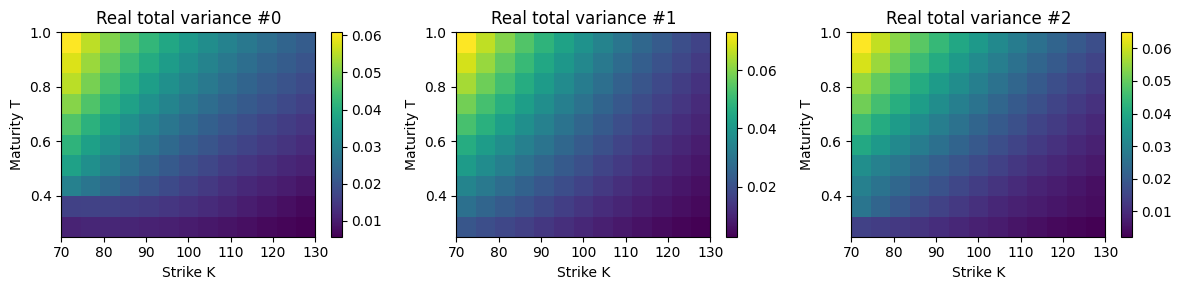

[Cond] Epoch 1/300, loss = 0.768117
[Cond] Epoch 2/300, loss = 0.406306
[Cond] Epoch 3/300, loss = 0.247693
[Cond] Epoch 4/300, loss = 0.219098
[Cond] Epoch 5/300, loss = 0.191834
[Cond] Epoch 6/300, loss = 0.148757
[Cond] Epoch 7/300, loss = 0.126830
[Cond] Epoch 8/300, loss = 0.124685
[Cond] Epoch 9/300, loss = 0.091270
[Cond] Epoch 10/300, loss = 0.117076
[Cond] Epoch 11/300, loss = 0.091572
[Cond] Epoch 12/300, loss = 0.088575
[Cond] Epoch 13/300, loss = 0.089257
[Cond] Epoch 14/300, loss = 0.061857
[Cond] Epoch 15/300, loss = 0.089842
[Cond] Epoch 16/300, loss = 0.057832
[Cond] Epoch 17/300, loss = 0.061723
[Cond] Epoch 18/300, loss = 0.076797
[Cond] Epoch 19/300, loss = 0.066937
[Cond] Epoch 20/300, loss = 0.068496
[Cond] Epoch 21/300, loss = 0.079010
[Cond] Epoch 22/300, loss = 0.056878
[Cond] Epoch 23/300, loss = 0.065025
[Cond] Epoch 24/300, loss = 0.053344
[Cond] Epoch 25/300, loss = 0.055853
[Cond] Epoch 26/300, loss = 0.057456
[Cond] Epoch 27/300, loss = 0.064397
[Cond] Epo

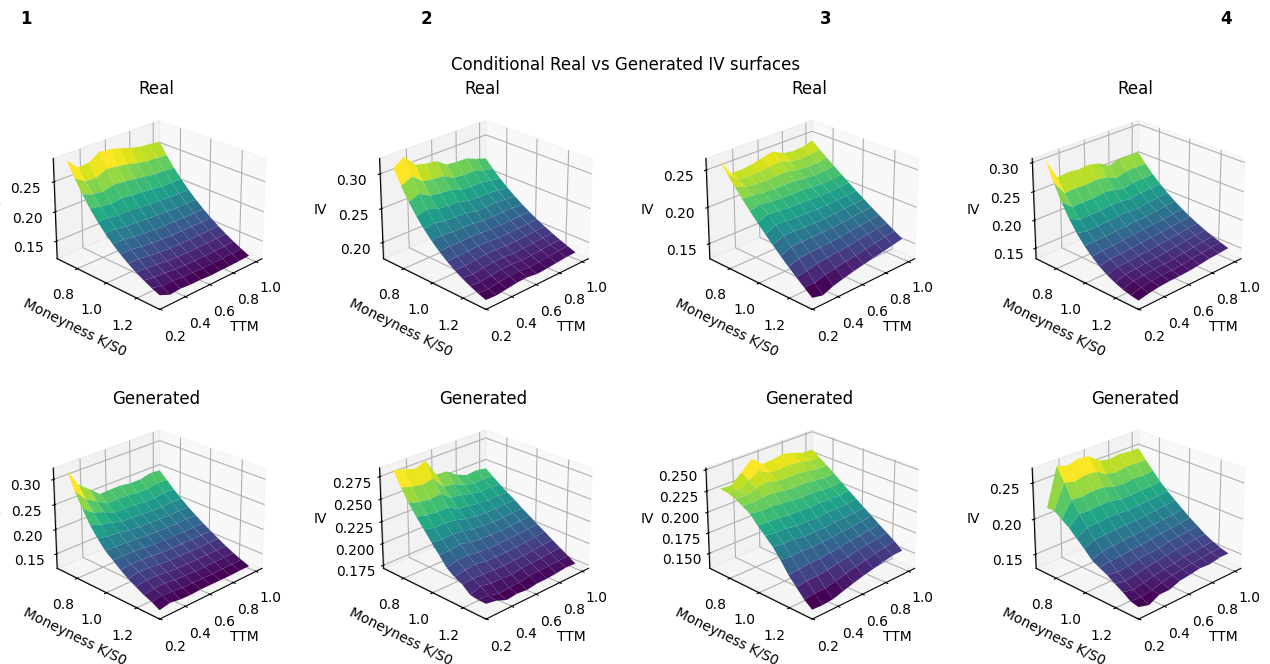

In [8]:
S0 = 100.0
r   = 0.01
T_list = np.linspace(0.25, 1.0, 10)
K_list = np.linspace(70, 130, 13)

dataset = IVSurfaceDatasetCond(
    n_samples=200,
    S0=S0,
    r=r,
    T_list=T_list,
    K_list=K_list,
    T_total=1.0,
    n_paths_mc=20000,
    seed=0,
)

H = len(T_list)
W = len(K_list)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i in range(3):
    tv_norm, _ = dataset[i]
    tv = tv_norm[0].numpy() * dataset.std + dataset.mean
    im = axes[i].imshow(
        tv,
        origin="lower",
        extent=[K_list[0], K_list[-1], T_list[0], T_list[-1]],
        aspect="auto",
    )
    axes[i].set_title(f"Real total variance #{i}")
    axes[i].set_xlabel("Strike K")
    axes[i].set_ylabel("Maturity T")
    fig.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.show()

diff_cfg = DiffusionConfig(timesteps=200, beta_start=1e-4, beta_end=0.02)
model = train_conditional_diffusion_model(
    dataset,
    diff_cfg,
    num_epochs=300,
    batch_size=16,
    lr=1e-4,
)

z_all = dataset.params.to(device)
gen_tv_norm = sample_surfaces_conditional(
    model, diff_cfg, z_all, img_shape=(1, H, W)
).cpu().numpy()

tau = np.array(T_list).reshape(1, H, 1)
gen_tv = gen_tv_norm[:, 0, :, :] * dataset.std + dataset.mean
gen_sigma = np.sqrt(np.maximum(gen_tv / tau, 1e-8))


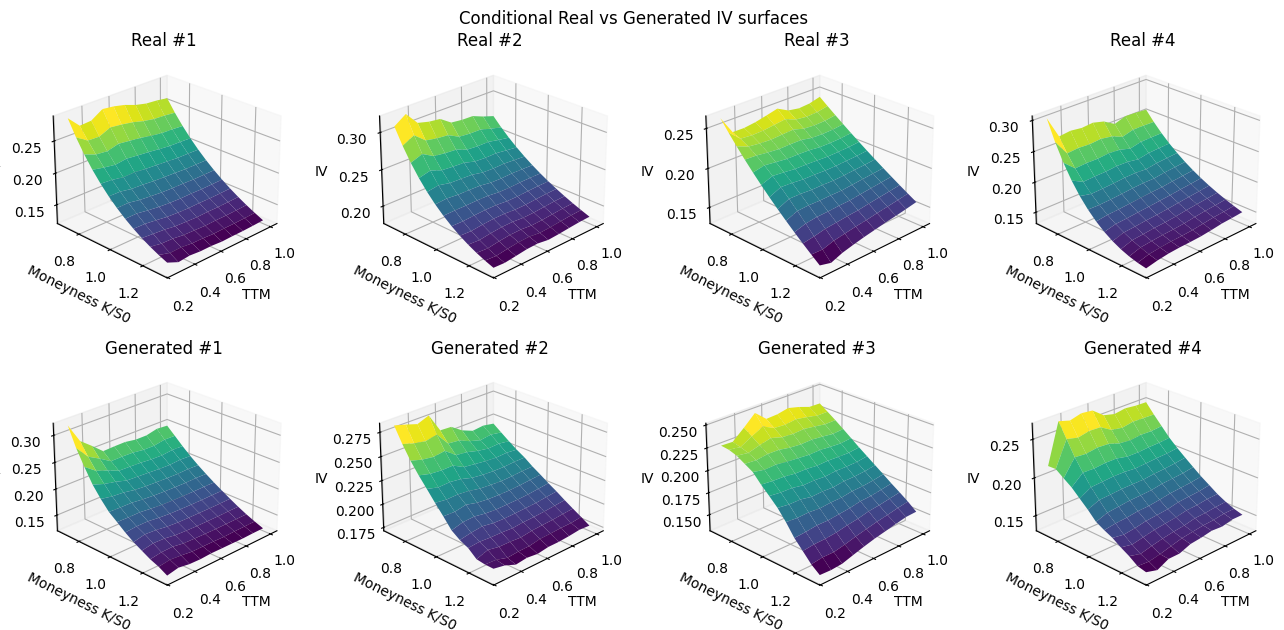

In [12]:

# 9.4 Real vs Generated conditioned
plot_real_vs_generated_pairs_3d_cond(
    dataset, gen_sigma, T_list, K_list,
    S0=S0, n_pairs=4, seed=42
)



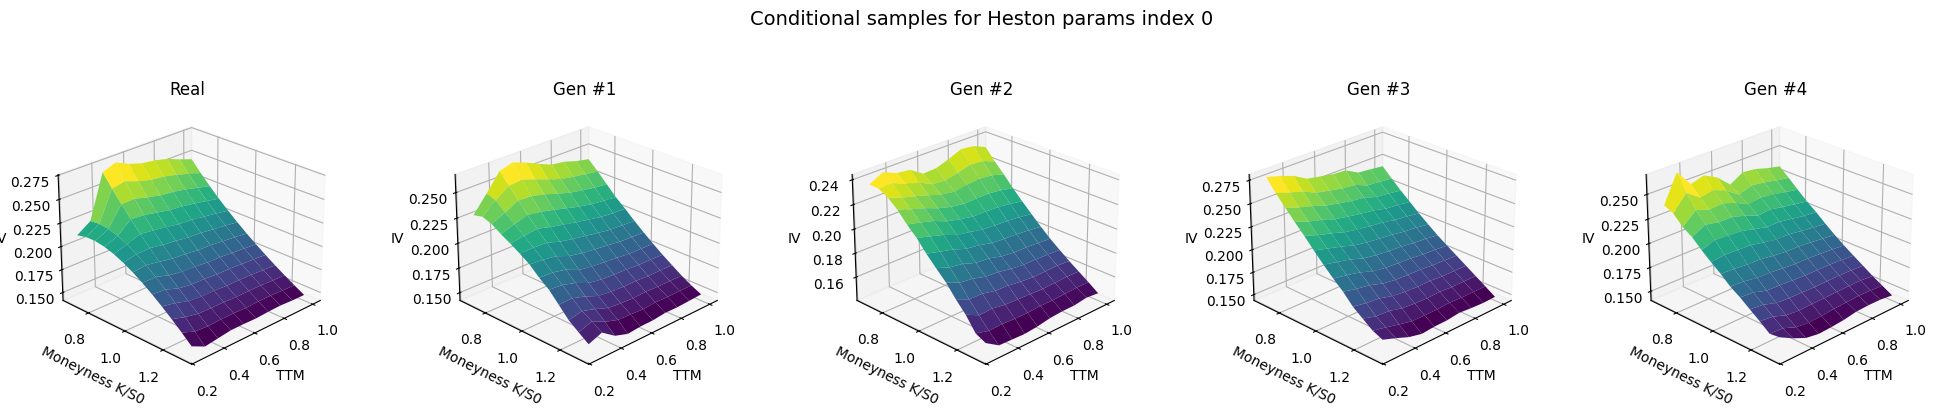

Raw Heston params (kappa, theta, eta, rho, v0): [ 2.1095693   0.03447488  0.36229205 -0.68951     0.04751848]

===== Evaluation: real vs generated IV surfaces =====

[ATM vol stats]
T=0.25  real mean/std=0.1905/0.0141,  gen mean/std=0.1872/0.0135
T=0.33  real mean/std=0.1891/0.0136,  gen mean/std=0.1864/0.0128
T=0.42  real mean/std=0.1878/0.0132,  gen mean/std=0.1864/0.0121
T=0.50  real mean/std=0.1866/0.0129,  gen mean/std=0.1846/0.0118
T=0.58  real mean/std=0.1857/0.0129,  gen mean/std=0.1833/0.0117
T=0.67  real mean/std=0.1851/0.0128,  gen mean/std=0.1826/0.0116
T=0.75  real mean/std=0.1846/0.0128,  gen mean/std=0.1825/0.0116
T=0.83  real mean/std=0.1843/0.0127,  gen mean/std=0.1820/0.0117
T=0.92  real mean/std=0.1842/0.0127,  gen mean/std=0.1821/0.0116
T=1.00  real mean/std=0.1841/0.0127,  gen mean/std=0.1824/0.0117

[Skew stats: sigma(T,K_min) - sigma(T,K_max)]
T=0.25  real mean/std=0.1767/0.0480,  gen mean/std=0.1531/0.0444
T=0.33  real mean/std=0.1686/0.0404,  gen mean/std=0.148

In [10]:

# fixed parameter，sampling multiple times
plot_conditional_samples_for_fixed_params(
    dataset, model, diff_cfg,
    idx=0, n_samples=4
)

evaluate_surfaces(dataset, T_list, K_list, gen_sigma, S0=S0, r=r)
print("Conditional Heston‑IV diffusion experiment done.")